In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.pyiron_base import load_workflow_json
from pyiron_base import Project

from aiida import load_profile
load_profile()

workflow_json_filename =  "aiida_to_pyiron_base_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph
from typing import Any

In [3]:
# NOTE: `get_dict` is `get_input_dict`, to compile the input values for the calc tasks
# NOTE: `add_link` must be from outputs to inputs
from python_workflow_definition.aiida import construct_wg_qe
from python_workflow_definition.shared import get_dict, get_list

In [4]:
@task.pythonjob()
def pickle_node(value):
    """Handle data nodes"""
    return value

In [5]:
from quantum_espresso_workflow import generate_structures as _generate_structures
from quantum_espresso_workflow import get_bulk_structure as _get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve as _plot_energy_volume_curve

In [6]:
strain_lst = [0.9, 0.95, 1.0, 1.05, 1.1]

In [7]:
get_bulk_structure = task.pythonjob()(_get_bulk_structure)
generate_structures = task.pythonjob()(_generate_structures)
calculate_qe = task.pythonjob(outputs=["energy", "volume", "structure"])(
    _calculate_qe
)
plot_energy_volume_curve = task.pythonjob()(_plot_energy_volume_curve)

In [8]:
wg = WorkGraph("wg-qe")

In [9]:
pickle_element_task = wg.add_task(
    pickle_node,
    name="pickle_element",
    value="Al",
)

In [10]:
pickle_a_task = wg.add_task(
    pickle_node, name="pickle_a", value=4.05
)

In [11]:
pickle_cubic_task = wg.add_task(
    pickle_node, name="pickle_cubic", value=True
)

In [12]:
pickle_relax_workdir_task = wg.add_task(
    pickle_node,
    name="pickle_relax_workdir",
    value="mini",
)

In [13]:
# ? relax or SCF, or general? -> Should be relax
relax_get_dict_task = wg.add_task(
    task.pythonjob(
        # outputs=["structure", "calculation", "kpts", "pseudopotentials", "smearing"]
        # outputs=["dict"]
    )(get_dict),
    name="relax_get_dict",
    register_pickle_by_value=True,
)

In [14]:
pickle_pp_task = wg.add_task(
    pickle_node,
    name="pseudopotentials",
    value={"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"},
)

In [15]:
pickle_kpts_task = wg.add_task(
    pickle_node, name="kpts_task", value=[3, 3, 3]  # FIXME: Back to [3, 3, 3]
)

In [16]:
pickle_calc_type_relax_task = wg.add_task(
    pickle_node,
    name="calc_type_relax",
    value="vc-relax",
)

In [17]:
pickle_smearing_task = wg.add_task(
    pickle_node, name="smearing", value=0.02
)

In [18]:
strain_lst_task = wg.add_task(
    pickle_node,
    name="pickle_strain_lst",
    value=strain_lst,
)

In [19]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    register_pickle_by_value=True,
)

In [20]:
relax_task = wg.add_task(
    calculate_qe,
    # ! I don't like the `mini` name...
    name="mini",
    register_pickle_by_value=True,
)

In [21]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    register_pickle_by_value=True,
)

In [22]:
# here we add the structure outputs based on the number of strains
del wg.tasks.generate_structures.outputs["result"]

In [23]:
scf_qe_tasks = []
for i, strain in enumerate(strain_lst):
    generate_structures_task.add_output("workgraph.any", f"s_{i}")

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        register_pickle_by_value=True,
    )
    scf_qe_tasks.append(scf_qe_task)

In [24]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    register_pickle_by_value=True,
)

In [25]:
strain_dir_tasks, scf_get_dict_tasks = [], []
for i, strain in enumerate(strain_lst):
    strain_dir = f"strain_{i}"

    strain_dir_task = wg.add_task(
        pickle_node,
        name=f"pickle_{strain_dir}_dir",
        value=strain_dir,
        register_pickle_by_value=True,
    )
    strain_dir_tasks.append(strain_dir_task)

    scf_get_dict_task = wg.add_task(
        task.pythonjob()(get_dict),
        name=f"get_dict_{i}",
        register_pickle_by_value=True,
    )
    scf_get_dict_tasks.append(scf_get_dict_task)

    if i == 0:
        pickle_calc_type_scf_task = wg.add_task(
            pickle_node,
            name="calc_type_scf",
            value="scf",
        )

In [26]:
get_volumes_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_volumes",
    register_pickle_by_value=True,
)

In [27]:
get_energies_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_energies",
    register_pickle_by_value=True,
)

In [28]:
# Add remaining links
wg.add_link(
    pickle_element_task.outputs.result, get_bulk_structure_task.inputs.element
)
wg.add_link(pickle_a_task.outputs.result, get_bulk_structure_task.inputs.a)
wg.add_link(pickle_cubic_task.outputs.result, get_bulk_structure_task.inputs.cubic)

NodeLink(from="pickle_cubic.result", to="get_bulk_structure.cubic")

In [29]:
# `.set` rather than `.add_link`, as get_dict takes `**kwargs` as input
relax_get_dict_task.set(
    {
        "structure": get_bulk_structure_task.outputs.result,
        "calculation": pickle_calc_type_relax_task.outputs.result,
        "kpts": pickle_kpts_task.outputs.result,
        "pseudopotentials": pickle_pp_task.outputs.result,
        "smearing": pickle_smearing_task.outputs.result,
    }
)

In [30]:
wg.add_link(relax_get_dict_task.outputs.result, relax_task.inputs.input_dict)
wg.add_link(
    pickle_relax_workdir_task.outputs.result,
    relax_task.inputs.working_directory,
)

NodeLink(from="pickle_relax_workdir.result", to="mini.working_directory")

In [31]:
wg.add_link(relax_task.outputs.structure, generate_structures_task.inputs.structure)
wg.add_link(
    strain_lst_task.outputs.result, generate_structures_task.inputs.strain_lst
)

NodeLink(from="pickle_strain_lst.result", to="generate_structures.strain_lst")

In [32]:
for i, (scf_get_dict_task, scf_qe_task, strain_dir_task) in enumerate(
    list(zip(scf_get_dict_tasks, scf_qe_tasks, strain_dir_tasks))
):
    scf_get_dict_task.set(
        {
            "structure": generate_structures_task.outputs[f"s_{i}"],
            "calculation": pickle_calc_type_scf_task.outputs.result,
            "kpts": pickle_kpts_task.outputs.result,
            "pseudopotentials": pickle_pp_task.outputs.result,
            "smearing": pickle_smearing_task.outputs.result,
        }
    )
    wg.add_link(scf_get_dict_task.outputs.result, scf_qe_task.inputs.input_dict)
    wg.add_link(
        strain_dir_task.outputs.result, scf_qe_task.inputs.working_directory
    )

    # collect energy and volume
    # wg.add_link(scf_qe_task.outputs.energy, get_energies_task.inputs.kwargs)
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    # wg.add_link(scf_qe_task.outputs.volume, get_volumes_task.inputs.kwargs)
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [33]:
wg.add_link(
    get_volumes_task.outputs.result,
    plot_energy_volume_curve_task.inputs.volume_lst,
)

NodeLink(from="get_volumes.result", to="plot_energy_volume_curve.volume_lst")

In [34]:
wg.add_link(
    get_energies_task.outputs.result,
    plot_energy_volume_curve_task.inputs.energy_lst,
)

NodeLink(from="get_energies.result", to="plot_energy_volume_curve.energy_lst")

In [35]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [36]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)

0it [00:00, ?it/s]

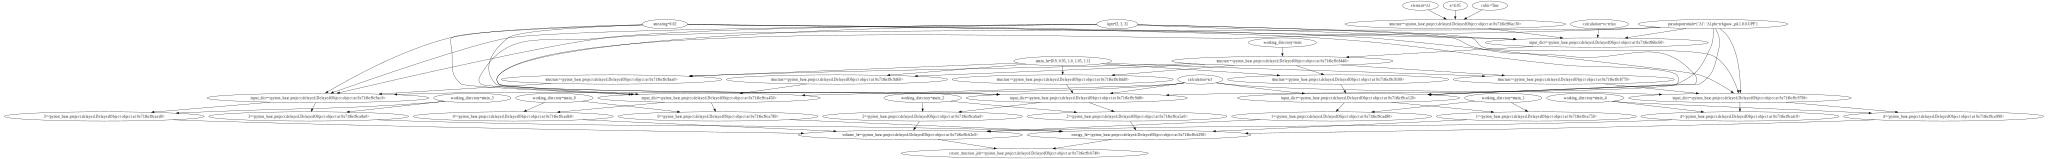

In [37]:
delayed_object.draw()


The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_22b5d0934d89d8f08761e744e4612c30 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-8esr8q3h:00369] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_27aeab6880c34540a9c765deda80d784 was saved and received the ID: 4
The job get_dict_56392dab5a2d38555828b1468d5e8287 was saved and received the ID: 5
The job calculate_qe_bd9b696e66da921fa544f1ad2b69aa33 was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-8esr8q3h:00411] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_c227b2e1715bd0f80fbe24b632771b94 was saved and received the ID: 7
The job calculate_qe_ba8d6500a3e3f0408c6ca19ff59fdfa4 was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-8esr8q3h:00442] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_83d16dc4d098b2e035fca90333aca031 was saved and received the ID: 9
The job calculate_qe_f7b748fd111920b3fb969ee2587b536c was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-8esr8q3h:00458] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_603887d10c637f43b4f90d6ddbb33013 was saved and received the ID: 11
The job calculate_qe_891be2cd796cb0adc95d358fa4133ed3 was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-8esr8q3h:00469] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_afcfad2368e2171e3180b69033224e43 was saved and received the ID: 13
The job calculate_qe_bc9abb6cf6d595892e6f855d1082e68a was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-8esr8q3h:00486] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_ca41097c0a5332599f7e520b68408ebd was saved and received the ID: 15
The job get_list_d61010ba7362bd7a5b1051e56d40f4cd was saved and received the ID: 16
The job plot_energy_volume_curve_219cb7246e0c237f48d2298204ff8273 was saved and received the ID: 17


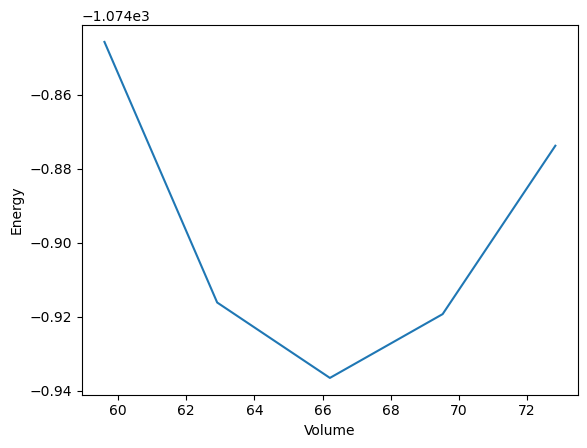

In [38]:

delayed_object.pull()
